In [1]:
import re as re

import pandas as pd
import numpy as np

from sklearn.manifold import TSNE
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%ls data

Air pollutant.csv
Dog and Cat food production EIO_LCA.xlsx
Energy.csv
GWP.csv
sector.csv


In [3]:
airpolu=pd.read_csv("data/Air pollutant.csv")
energy=pd.read_csv("data/Energy.csv")
GWP=pd.read_csv("data/GWP.csv")
sector=pd.read_csv("data/sector.csv")

In [4]:
def combineSector(df, df_sector):
    def find_number(text):
        num = re.findall(r'[0-9]+',text)
        return " ".join(num)

    def first2(text):
        return text[:2]
    df2 = df.copy()
    ID2 = df2['ID'].map(find_number).map(first2).astype('int64')
    df2.insert(loc=1, column='ID2', value=ID2)
    df_sector=df_sector.merge(df2, on='ID2', how='right')
    return df_sector

def tsneFind2Pinciple(df_sector):

    Principle = TSNE(n_components=2).fit_transform(df_sector.iloc[:,4:])
    Principle=pd.DataFrame(Principle, columns=['P1','P2'])
    new_df=df_sector.iloc[:,:4]
    new_df[['P1','P2']]=Principle
    return new_df

def addCluster(df_sector, df_principle):

    clustering = SpectralClustering(n_clusters=3, assign_labels='discretize',random_state=0).fit(df_principle[['P1','P2']])
    df_principle['cluster']=clustering.labels_
    return df_principle
    
def checkGroupAgg(df, df_sector_cluster, by=['cluster','Sector'], func = ['max','min']):
    df_cluster = pd.concat([df_sector_cluster[by], df.iloc[:,2:]], axis=1)
    return df_cluster.groupby(by).agg(func).style.highlight_max(axis=0)

def groupcount(df_sector_cluster):
    df = df_sector_cluster[['cluster','Sector','ID']].groupby(['cluster','Sector']).agg('count').reset_index(drop=False)
    df.columns=['cluster','Sector','count']
    return df.sort_values(by=['cluster','count'], ascending=False)

def masking0row(df):
    df_data=df.iloc[:,3:]
    mask = (df_data != 0).sum(1)!=0
    print('Drop', len(df[-mask]['Subsector']), 'unrelative subsectors that contain only zero \n',df[-mask]['Subsector'], )
    return df[mask]

def plot(df_sector_cluster, style="cluster", hue="cluster", size = None, figsize = (5,5), if_ledgend= True):
    plt.figure(figsize=figsize)
    g= sns.scatterplot(data=df_sector_cluster, x="P1", y="P2", style=style, hue=hue, size = size, palette="viridis")
    if if_ledgend:
        plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    else:
        plt.legend([],[], frameon=False)
    plt.show()

def plotHeatmap(df):
    # Compute the correlation matrix
    corr = df.iloc[:,2:].corr()
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    

In [5]:
df = airpolu.merge(GWP.drop(columns='Total t CO2e'), on=['ID', 'Subsector'])
scaler = MinMaxScaler(feature_range=(0,10))
df.iloc[:,2:] =scaler.fit_transform(df.iloc[:,2:])
df = masking0row(df).reset_index(drop=True)

Drop 26 unrelative subsectors that contain only zero 
 362    Commercial Structures, Including Farm Structures
363                    Elementary And Secondary Schools
364                        Federal Government (Defense)
365                     Federal Government (Nondefense)
366                                   Funerary Services
367      Gambling Establishments (Except Casino Hotels)
368                               Health Care Buildings
369                      Highways, Streets, And Bridges
370                                     Home Healthcare
371                                           Hospitals
372                                 Household Employees
373                                             Housing
374                             Manufacturing Buildings
375                                         Motor Homes
376                                   Multifamily Homes
377          Museums, Historical Sites, Zoos, And Parks
378                               Noncomparable I

In [ ]:
sns.pairplot(df.iloc[:,2:])

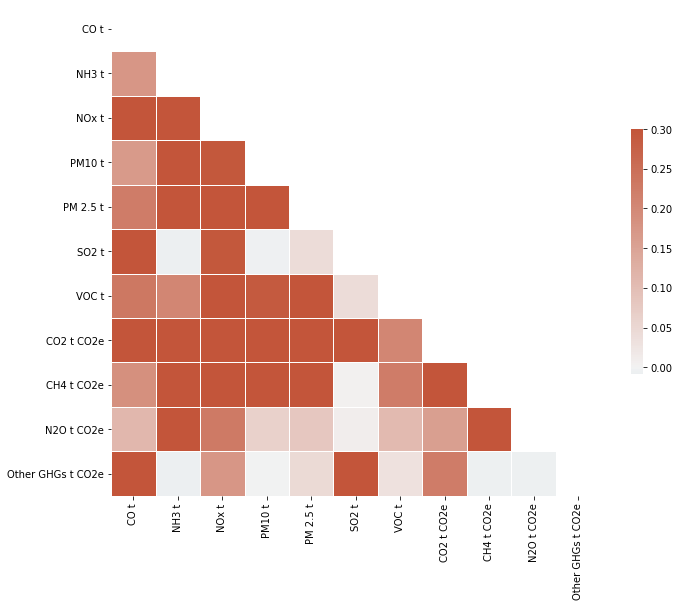

In [22]:
plotHeatmap(df)

In [6]:
sector = combineSector(df, df_sector=sector)
principle = tsneFind2Pinciple(sector)
sector_cluster= addCluster(df_sector=sector, df_principle=principle)

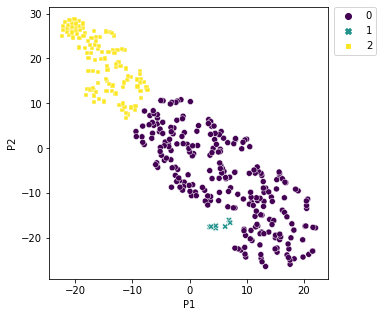

In [7]:
plot(sector_cluster, style='cluster', hue='cluster', if_ledgend= True)

CO t


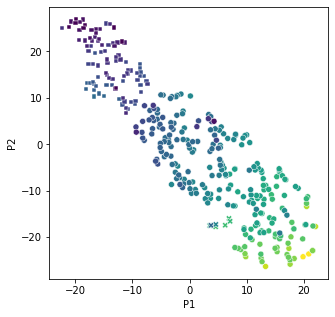

NH3 t


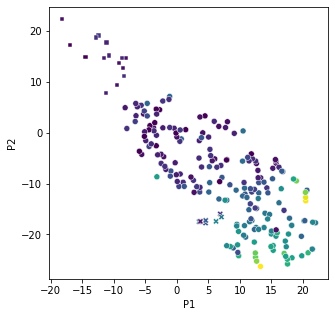

NOx t


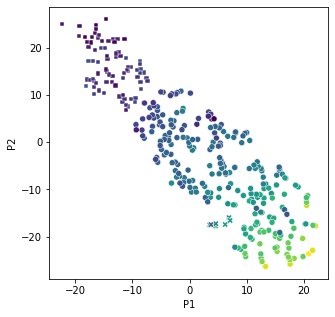

PM10 t


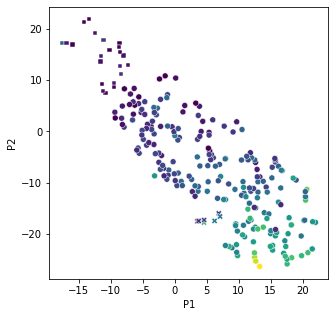

PM 2.5 t


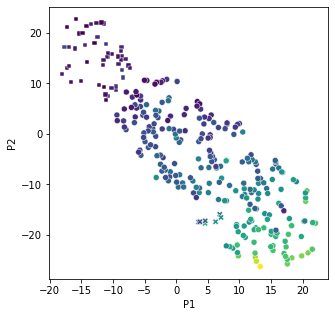

SO2 t


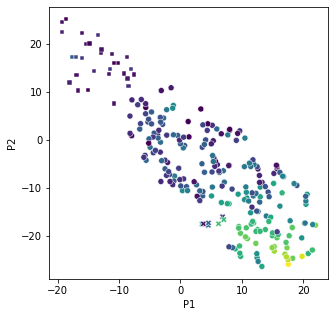

VOC t


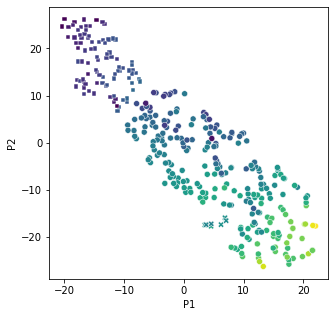

CO2 t CO2e


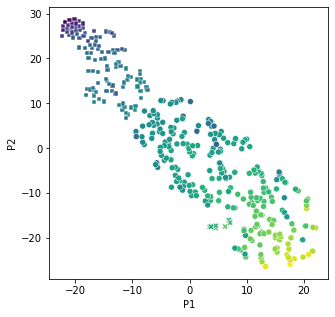

CH4 t CO2e


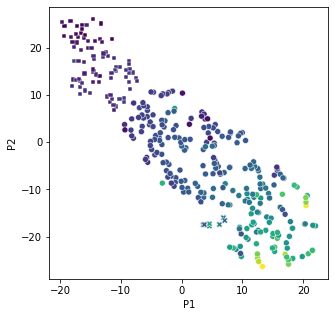

N2O t CO2e


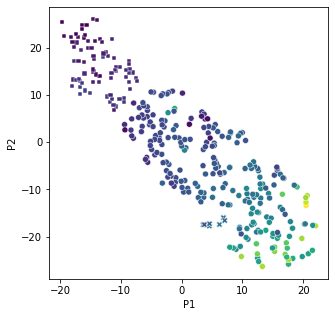

Other GHGs t CO2e


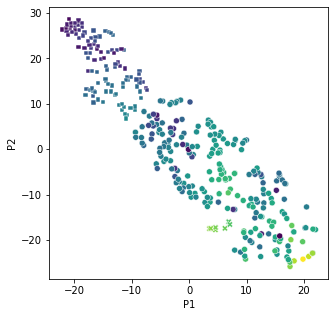

In [8]:
for col in df.columns[2:]:
    print(col)
    col0mask = df[col]!=0
    plot(sector_cluster[col0mask], hue=np.log(df[col][col0mask]), figsize = (5,5), if_ledgend = False) 

In [9]:
checkGroupAgg(df = energy, df_sector_cluster = sector_cluster,
             by=['cluster'], func = ['max','min'])

In [10]:
checkGroupAgg(df = energy, df_sector_cluster = sector_cluster,
             by=['cluster','Sector'], func = ['max','min'])

In [11]:
groupcount(sector_cluster)

,cluster,Sector,count
25,2,Manufacturing,78
23,2,Health Care and Social Assistance,11
24,2,Information,11
27,2,"Professional, Scientific, and Technical Services",4
26,2,Other Services (except Public Administration),3
20,2,Construction,2
28,2,Retail Trade,2
21,2,Educational Services,1
22,2,Finance and Insurance,1
19,1,Manufacturing,5
